## Apply Random Forest Regression to Stock Technical Indicators
### _Date 11.23.2017_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
import pickle

#### Load Data

In [13]:
f = open('pickle/ETC_prices.pkl', 'rb')
df = pickle.load(f)
df.columns = ['Close']
df.dropna(inplace=True)
df.tail()

,Close
date,
2018-08-28,12.964793
2018-08-29,13.019936
2018-08-30,12.621047
2018-08-31,12.664938
2018-09-01,13.174411


#### Compute Technical Indicators

In [10]:
def exp_Mov_Avg(myArr,N):
    EMA = np.zeros(len(myArr))
    EMA[0] = myArr[0]
    k = 2/(N+1)
    for i in range(1,len(myArr)):
        EMA[i] = myArr[i]*k + EMA[i-1]*(1-k)
    return EMA

def MACD(myArr,a=12,b=26):
    return exp_Mov_Avg(myArr,a)-exp_Mov_Avg(myArr,b)

def MACD2(myArr,a=12,b=26,c=9):
    MACD = exp_Mov_Avg(myArr,a)-exp_Mov_Avg(myArr,b)
    return [float(x) for x in MACD>exp_Mov_Avg(MACD,c)]

def oscillator(myArr_last, myArr_low, myArr_high):
    K = [float('nan') for x in range(13)]
    for i in range(13, len(myArr_last)):
        L14 = min(myArr_low[i-13:i+1])
        H14 = max(myArr_high[i-13:i+1])
        K.append(100*(myArr_last[i]-L14)/(H14-L14))
    return K

def williams(myArr_last, myArr_low, myArr_high):
    R = [float('nan') for x in range(13)]
    for i in range(13, len(myArr_last)):
        L14 = min(myArr_low[i-13:i+1])
        H14 = max(myArr_high[i-13:i+1])
        R.append((H14-myArr_last[i])/(H14-L14)*(-100))
    return R

def relative_Strength_Index(myArr):
    RSI = [float('nan') for x in range(14)]
    myDiff = np.array(myArr[1:])-np.array(myArr[0:len(myArr)-1])
    for i in range(14,len(myArr)):
        temp = myDiff[i-14:i]
        if len(temp[temp<=0])==0:
            RSI.append(100)
        else:
            RS = np.mean(temp[temp>0])/np.mean(-temp[temp<=0])
            RSI.append(100 - 100/(1+RS))
    return RSI

def money_flow_index(myArr_last, myArr_low, myArr_high,myArr_volume):
    myArr = (myArr_high+myArr_low+myArr_last)/3*myArr_volume
    return relative_Strength_Index(myArr)

def price_Change(myArr, n):
    myArr = np.array(myArr)
    PC = np.array([float('nan') for x in range(n)])
    PC = np.append(PC,myArr[n:]/myArr[0:len(myArr)-n]-1)
    return PC

def on_Balance_Volume(myArr_last, myArr_volume):
    obv = np.zeros(len(myArr_volume))
    obv[0] = myArr_volume[0]
    for i in range (1,len(myArr_last)):
        if myArr_last[i] > myArr_last[i-1]:
            obv[i] = obv[i-1] + myArr_volume[i]
        elif myArr_last[i] < myArr_last[i-1]:
            obv[i] = obv[i-1] - myArr_volume[i]
        else:
            obv[i] = obv[i-1]
    return obv

In [15]:
#df['Yt+30'] = [float(x) for x in data['Close'].shift(-30)>data['Close']]
df.loc[:, 'Rt+30'] = df['Close'].shift(-30)/df['Close']-1
df.loc[:, 'MACD'] = MACD(df['Close'])

# exp smoothing
df.loc[:, 'Close'] = exp_Mov_Avg(df['Close'], 2)
#data.loc[:, 'Low'] = exp_Mov_Avg(data['Low'], 2)
#data.loc[:, 'High'] = exp_Mov_Avg(data['High'], 2)
#data.loc[:, 'Volume'] = exp_Mov_Avg(data['Volume'], 2)

#df.loc[:, 'Oscillator'] = oscillator(df['Close'], df['Low'], df['High'])
#df.loc[:, 'Williams'] = williams(df['Close'], df['Low'], df['High'])
df.loc[:, 'RSI'] = relative_Strength_Index(df['Close'])
#df.loc[:, 'MFI'] = money_flow_index(df['Close'], df['Low'], df['High'], df['Volume'])
df.loc[:, 'Price_Chg1'] = price_Change(df['Close'],1)
df.loc[:, 'Price_Chg2'] = price_Change(df['Close'],2)
df.loc[:, 'Price_Chg3'] = price_Change(df['Close'],3)
df.loc[:, 'Price_Chg5'] = price_Change(df['Close'],5)
df.loc[:, 'Price_Chg8'] = price_Change(df['Close'],8)
df.loc[:, 'Price_Chg13'] = price_Change(df['Close'],13)
df.loc[:, 'Price_Chg21'] = price_Change(df['Close'],21)
df.loc[:, 'Price_Chg30'] = price_Change(df['Close'],30)
df.loc[:, 'Price_Chg60'] = price_Change(df['Close'],60)
#df.loc[:, 'OBV'] = on_Balance_Volume(df['Close'], df['Volume'])

In [8]:
df = df[df.index>="1992/04/01"] # remove observations at the beginning to avoid nan and volatile EMA
df = df[:-30] # remove last 30 days due to lack of Y_{t+30}
df = pd.DataFrame.dropna(df) # remove rows that still contains nan
df_train = df[df.index<"2016/01/01"] # training set 1986~2015
df_test = df[df.index>="2016/01/01"] # test set 2016~2017

#### Random Forest Regression

In [16]:
features = ['MACD','Oscillator','Williams','RSI','MFI','Price_Chg1','Price_Chg2','Price_Chg3',
            'Price_Chg5','Price_Chg8','Price_Chg13','Price_Chg21','Price_Chg30','Price_Chg60','OBV']
X_train = df_train[features]
Y_train = df_train['Rt+30']
param_grid = {'n_estimators': [500], 'max_features': [3,4,5],'min_samples_leaf':[4,6,8]}
rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
rfr.fit(X_train, Y_train)
print(rfr.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


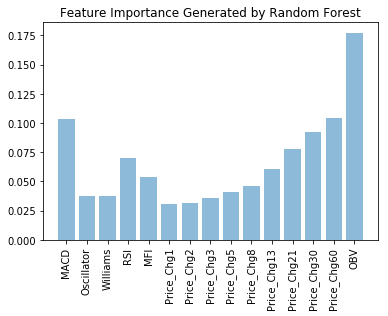

In [17]:
#Function: Plot Random Forest Regressor Feature Importance:
def plot_rfr(estimator,features):
    y_pos = np.arange(len(features))
    plt.bar(y_pos, estimator.best_estimator_.feature_importances_, align='center', alpha=0.5)
    plt.xticks(y_pos, features)
    plt.title("Feature Importance Generated by Random Forest")
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
    plt.show()

plot_rfr(rfr,features)

In [49]:
df_test['Rt+30_hat'] = rfr.predict(df_test[features])
rt30 = df_test['Rt+30']
rt30_hat = df_test['Rt+30_hat']

# robustness parameters for binary classifiers
tp = sum(np.array([float(x) for x in rt30>0]) * np.array([float(x) for x in rt30_hat>0]))
tn = sum(np.array([float(x) for x in rt30<0]) * np.array([float(x) for x in rt30_hat<0]))
fp = sum(np.array([float(x) for x in rt30<0]) * np.array([float(x) for x in rt30_hat>0]))
fn = sum(np.array([float(x) for x in rt30>0]) * np.array([float(x) for x in rt30_hat<0]))
print(tp)
print(tn)
print(fp)
print(fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)
print(accuracy)
print(precision)
print(recall)
print(specificity)

166.0
196.0
27.0
57.0
0.811659192825
0.860103626943
0.744394618834
0.878923766816


C:\Python666\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [50]:
# total returns
profit = rt30
profit[rt30_hat<0] = -rt30
print(sum(profit.resample('M','last'))/22*12)
print(sum(profit.resample('M','first'))/22*12)

0.396704132958
0.333221129561


C:\Python666\lib\site-packages\pandas\core\generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Python666\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Python666\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
C:\Python666\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
